# EP2 - Conjunto de Maldelbrot e paralelização com CUDA e OMPI


## Configuração do ambiente

Atualizando os pacotes Julia

In [1]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


Verificando o status dos pacotes, e se há algum problema, com o comando:

In [2]:
] st

    Status `~/.julia/environments/v1.3/Project.toml`
  [336ed68f] CSV v0.7.3
  [a93c6f00] DataFrames v0.21.4
  [31c24e10] Distributions v0.23.4
  [7073ff75] IJulia v1.21.2
  [b964fa9f] LaTeXStrings v1.1.0
  [8314cec4] PGFPlotsX v1.2.8
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6
  [10745b16] Statistics 


Chamando pacotes que usaremos:

In [3]:
using DataFrames, Query, StatsPlots, Statistics

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


## Verificando compilação pelo notebook

In [4]:
; make mandelbrot_cuda

make: 'mandelbrot_cuda' is up to date.


In [6]:
; ./mandelbrot_cuda

usage: ./mandelbrot_seq c_x_min c_x_max c_y_min c_y_max image_size
examples with image_size = 11500:
    Full Picture:         ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500
    Seahorse Valley:      ./mandelbrot_seq -0.8 -0.7 0.05 0.15 11500
    Elephant Valley:      ./mandelbrot_seq 0.175 0.375 -0.1 0.1 11500
    Triple Spiral Valley: ./mandelbrot_seq  


In [6]:
; ./mandelbrot_cuda 0.175 0.375 -0.1 0.1 200 4 4

0.009179,0.241526


## Funções para realização dos experimentos

A função abaixo recebe parâmetros:

- `mandel`, com o nome da função a ser executada (`./mandelbrot_seq`, `./mandelbrot_opm`, `./mandelbrot_pth`, `./mandelbrot_ompi` ou `./mandelbrot_cuda`);
- `thread`, com o número de threads do programa paralelo, caso a implementacao seja em pthreads ou OpenMP;
- `process`, com a quantidade de processos para a implementação em OMPI;
- `grid` e `bloco`, com a dimensão do grid e quantidade de blocos para a implementação em CUDA.

A função executa o programa `mandelbrot` com os parâmetros dados e devolve um `DataFrame` com os resultados.

In [5]:
function measure_mandelbrot(mandel; thread = 0, process = 0, grid = 0, bloco = 0)    
    
    # para este EP só serao feitas comparacoes usando a regiao triple spiral
    mode = `-0.188 -0.012 0.554 0.754` #triple spiral
    size = 4096
    
    if thread != 0       # PThreads e OpenMP
        results = parse.(Float64,
            split(chomp(read(`./$mandel $mode $size $thread `, String)), ","))
        
    else
        
        if process != 0  # OMPI
            results = parse.(Float64, 
                        split(chomp(read(mpirun -n $process ./$mandel $mode $size , String)), ","))
        else
            
            if grid != 0 # CUDA
                println(grid,bloco)
                results = parse.(Float64,
                        split(chomp(read(`./$mandel $mode $size $grid $bloco `, String)), ","))
            
            else         # Sequencial
                results = parse.(Float64,
                    split(chomp(read(`./$mandel $mode $size`, String)), ","))
            end  
        end 
    end
    
    return DataFrame(
        threads = thread,
        processes = process,
        griddim = grid,
        blocos = bloco,
        duration = results[1],
        io_alocation = results[2])
end

ErrorException: syntax: "$" expression outside quote

A função `run_experiments` recebe os mesmos parâmetros `mandel`, `threads`, `process`, `grid` e `bloco` e um parâmetro adicional `repetitions`, com o número de repetições de cada experimento. A função devolve um `DataFrame` com todos os experimentos.

In [6]:
function run_experiments(mandel, repetitions; threads = [], process = [], grid = [], bloco = [])
    run(`make $mandel`)
        
    results = DataFrame(
        threads = Int[],
        processes = Int[],
        griddim = Int[],
        blocos = Int[],
        duration = Float64[],
        io_alocation = Float64[]) 
    
    if threads != [] # Implementação em OpenMP ou PThreads
    
        for t in threads
            for r in 1:repetitions
                append!(results,
                    measure_mandelbrot(mandel, thread = t))    
            end
        end
        
    else
        if process != [] # Implementação em OMPI
            
            for p in process
                println("process",p)
                for r in 1:repetitions
                    println("rep",r)
                    append!(results,
                        measure_mandelbrot(mandel, process = p))    
                end
            end 
        else
            if grid != [] # Implementação em CUDA
                println("Started")
                for g in grid
                    println("grid: ",g)
                    for b in bloco
                        println("bloco: ",b)
                        for r in 1:repetitions
                            println("rep: ",r)
                            append!(results,
                                measure_mandelbrot(mandel, grid = g, bloco  = b))    
                        end
                    end
                end 
                
            else 
                # Implementação sequencial
                for r in 1:repetitions
                    for s in size
                        append!(results,
                            measure_mandelbrot(mandel))    
                    end
                end
            end
        end
    end
    
    return results
end

run_experiments (generic function with 1 method)

A função `parse_results` recebe um `DataFrame` de resultados, produzido pela função `run_experiments`. A função devolve um `DataFrame` com a média e o intervalo de confiança da média a 95% dos tempos de execução, agrupados por número de threads, processos, dimensao do grid e quantidade de blocos.

In [7]:
function parse_results(results)
    parsed_results = results |>
                    @groupby({_.threads, _.processes,_.griddim,_.blocos}) |>
                    @map({threads = key(_).threads,
                          processes = key(_).processes,
                          griddim = key(_).griddim,
                          blocos = key(_).blocos,  
                          mean_duration = mean(_.duration),
                          mean_io_alocation = mean(_.io_alocation),
                          ci_duration = 1.96 * std(_.duration),
                          ci_io_alocation = 1.96 * std(_.io_alocation)}) |>
                    DataFrame
    
    return parsed_results
end

parse_results (generic function with 1 method)

## Funções para traçar gráficos

A função abaixo permite que sejam traçadas até 5 séries de dados em um mesmo gráfico do tipo scatter.

In [21]:
pgfplotsx()

function plot_results(x, y, series_label, yerror; x2 = x, y2 = [], series_label2 = [], yerror2 = [], 
        title = "", xaxis = "Threads", max_thread_power = 5)
    
    p = scatter(x, y, xaxis = :log2, xlabel = xaxis, xticks = [2 ^ x for x in 0:max_thread_power],
        yerror = yerror, alpha = 0.6, 
        labels = series_label, legend = :best, title = title)
    
    if y2 != []
        p = scatter!(x2, y2, xaxis = :log2, xticks = [2 ^ x for x in 0:max_thread_power],
            yerror = yerror2, alpha = 0.6,
            labels = series_label2, legend = :best)
    end
    
    return p
end

plot_results (generic function with 1 method)

## Condições para os experimentos

O tamanho da imagem em 4096 e a região como sendo a Triple Spiral Valley estão definidas internamente nas funções.

In [9]:
thread =  [2 ^ x for x in 0:5]
processes = [2 ^ x for x in 0:6]  # OMPI
size = [2^12]
grids = [2 ^ x for x in 3:4]
blocos = [2^x for x in 3:4]
repetitions = 15;

# Sobre as implementações em CUDA e OMPI

## CUDA

Na implementação em CUDA, foi utilizado um grid onde são especfiicados $n$ e $m$, onde o grid terá dimensão de $n vs. n$ blocos e cada bloco terá $m vs. m$ threads. O número de tarefas (cáculo do número de iterações de uma posição) é calculado de acordo com o número de threads disponíveis. Se o número total de threads for maior do que o número de tarefas, cada thread recebe uma tarefa para ser feita e uma parte fica ociosa. Se o número total de threads for menor, cada thread calculará o número de iterações de sua posição e de seus vizinhos, aumentando o número de vizinhos calculados de acordo com a razão número de tarefas por número de threads.

É esperado que caso as dimensões do grid e do bloco sejam pequenas demais, o programa se aproxime da implementação sequencial, pois uma menor quantidade de paralelizações estará sendo feita. Por outro lado, se as dimensões especificadas forem grandes demais, o número de threads sem tarefas será alto e o manejamento delas, um processo desnecessário em execução.

## OMPI

A implementação do OMPI foi feita utilizando alocação dinâmica de tarefas. Diferentemente do CUDA, temos um limite bem menor de processos que podem ser utilizados. Portanto, tem maior cabimento uma implementação parecida com a de pThreads, onde cada processo se responsabiliza por uma linha inteira da matriz image_buffer, na intenção de não saturar o processo raiz. Este por sua vez (implementada no rank 0) é responsável por administrar os outros processos e assinalar as tarefas. O processo raiz primeiro irá se certificar de que todos os processos estejam trabalhando assinalando novos trabalhos àqueles que estiverem ociosos e logo após esperará que algum deles envie sua resposta calculada. Nesse momento, o processo raiz registra a resposta recebida no image_buffer e sinaliza que tal processo se tornou ocioso. A ação se repete até que todas as respostas sejam registradas no image_buffer.

Para a implementação feita não é possível executar o programa com apenas um processo. É interessante notar que o programa executará infinitamente sem terminar a tarefa, pois haverá apenas o processo raiz administrando outros processos, que nesse caso são inexistentes, o que fará com que o programa congele. De fato isso pode ser considerado uma desvantagem, porém, do ponto de vista de implementação, a alocação dinâmica de trabalho gera muitos benefícios para valores maiores (e mais usuais) de processos, pois há a garantia de que não haverão processos ociosos continuamente.

# Gerando e Salvando dados

## Mandelbrot sequencial

Realizando as medições para o mandelbrot sequencial:

In [73]:
results_seq_triplespiral = run_experiments("mandelbrot_seq", repetitions);
seq_triplespiral = parse_results(results_seq_triplespiral);

make: 'mandelbrot_seq' is up to date.


## Mandelbrot com pthreads

Realizando as medições para o mandelbrot com PThreads:

In [26]:
results_pth_triplespiral = run_experiments("mandelbrot_pth", repetitions, threads=thread);
pth_triplespiral = parse_results(results_pth_triplespiral);

make: 'mandelbrot_pth' is up to date.


## Mandelbrot com OpenMP

Realizando as medições para o mandelbrot com OpenMP:

In [ ]:
results_omp_triplespiral = run_experiments("mandelbrot_omp", repetitions, threads=thread);
omp_triplespiral = parse_results(results_omp_triplespiral);

## Mandelbrot com OMPI

Realizando as medições para o mandelbrot com OMPI:

In [ ]:
results_ompi_triplespiral = run_experiments("mandelbrot_ompi", repetitions, process=processes);
ompi_triplespiral = parse_results(results_ompi_triplespiral);

## Mandelbrot com CUDA

Realizando as medições para o mandelbrot com CUDA:

In [33]:
results_cuda_triplespiral = run_experiments("mandelbrot_cuda", repetitions, grid = grids, bloco = blocos)
cuda_triplespiral = parse_results(results_cuda_triplespiral)

make: 'mandelbrot_cuda' is up to date.
Started
grid: 8
bloco: 8
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
bloco: 16
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
grid: 16
bloco: 8
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15
bloco: 16
rep: 1
rep: 2
rep: 3
rep: 4
rep: 5
rep: 6
rep: 7
rep: 8
rep: 9
rep: 10
rep: 11
rep: 12
rep: 13
rep: 14
rep: 15


,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,0,8,8,1.4775,1.70574,0.0367937
2,0,0,8,16,1.44746,1.6804,0.034053
3,0,0,16,8,1.43918,1.67566,0.0299027
4,0,0,16,16,1.40601,1.64012,0.0203941


## Salvando dados

In [10]:
using CSV

function save_csv_results(results,filename)
    println(filename)
    CSV.write(filename, results)
end

┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


save_csv_results (generic function with 1 method)

In [137]:
save_csv_results(results_seq_triplespiral,"data/results_seq_triplespiral.csv");
save_csv_results(seq_triplespiral,"data/seq_triplespiral.csv");

data/results_seq_full.csv
data/results_seq_triplespiral.csv
data/results_seq_elephant.csv
data/results_seq_seahorse.csv
data/seq_full.csv
data/seq_triplespiral.csv
data/seq_elephant.csv
data/seq_seahorse.csv


In [138]:
save_csv_results(results_omp_triplespiral,"data/results_omp_triplespiral.csv");
save_csv_results(omp_triplespiral,"data/omp_triplespiral.csv");

data/results_omp_full.csv
data/results_omp_triplespiral.csv
data/results_omp_elephant.csv
data/results_omp_seahorse.csv
data/omp_full.csv
data/omp_triplespiral.csv
data/omp_elephant.csv
data/omp_seahorse.csv


In [51]:
save_csv_results(results_pth_triplespiral,"data/results_pth_triplespiral.csv");
save_csv_results(pth_triplespiral,"data/pth_triplespiral.csv");

data/results_pth_full.csv
data/results_pth_triplespiral.csv
data/results_pth_elephant.csv
data/results_pth_seahorse.csv
data/pth_full.csv
data/pth_triplespiral.csv
data/pth_elephant.csv
data/pth_seahorse.csv


In [ ]:
save_csv_results(results_ompi_triplespiral,"data/results_ompi_triplespiral.csv");
save_csv_results(ompi_triplespiral,"data/ompi_triplespiral.csv");

In [35]:
save_csv_results(results_cuda_triplespiral,"data/results_cuda_triplespiral.csv");
save_csv_results(cuda_triplespiral,"data/cuda_triplespiral.csv");

data/results_cuda_triplespiral.csv
data/cuda_triplespiral.csv


# Lendo dados

In [11]:
using CSV

function read_csv_results(filename)
    results=CSV.read(filename)
    return results
end

read_csv_results (generic function with 1 method)

Os gráficos iniciados por "results" são aqueles que não possuem suas informações agregadas (como média e intervalo de confiança). Carregando os dataframes gerados, para testes futuros:

In [29]:
#seq_triplespiral=read_csv_results("data/seq_triplespiral.csv");
#omp_triplespiral=read_csv_results("data/omp_triplespiral.csv");
#pth_triplespiral=read_csv_results("data/pth_triplespiral.csv");
ompi_triplespiral=read_csv_results("data/ompi_triplespiral.csv");
cuda_triplespiral=read_csv_results("data/cuda_triplespiral.csv");

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40


In [30]:
#results_seq_triplespiral=read_csv_results("data/results_seq_triplespiral.csv");
#results_omp_triplespiral=read_csv_results("data/results_omp_triplespiral.csv");
#results_pth_triplespiral=read_csv_results("data/results_pth_triplespiral.csv");
results_ompi_triplespiral=read_csv_results("data/results_ompi_triplespiral.csv");
results_cuda_triplespiral=read_csv_results("data/results_cuda_triplespiral.csv");

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40
┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `DataFrame!(CSV.File(input; kw...))`
└ @ CSV /home/lune/.julia/packages/CSV/W9RT2/src/CSV.jl:40


# Gráficos comparativos


## Comparando desempenho 

### Sequencial

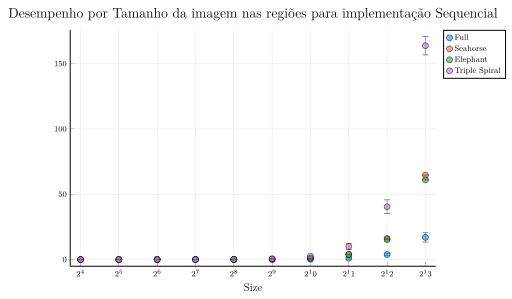

In [142]:
plot_results(seq_triplespiral.size, seq_triplespiral.mean_duration, "Triple Spiral", seq_full.ci_duration,
    title = "Desempenho por Tamanho da imagem para implementação Sequencial",
    xaxis = "Size", max_thread_power = 5)

### OpenMP

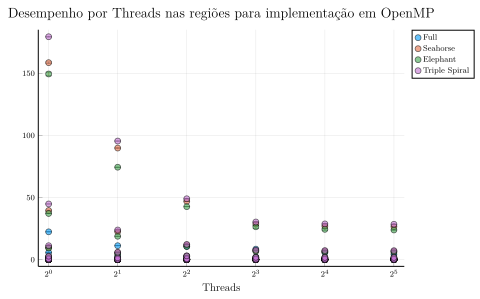

In [140]:
plot_results(omp_triplespiral.threads, omp_triplespiral.mean_duration, "Triple Spiral",
    omp_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em OpenMP", max_thread_power = 5)

### PThreads

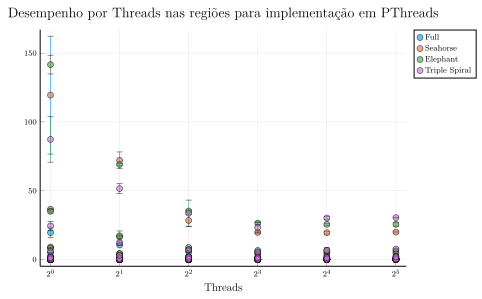

In [141]:
plot_results(pth_triplespiral.threads, pth_triplespiral.mean_duration, "Triple Spiral",
    pth_triplespiral.ci_duration,
    title = "Desempenho por Threads nas regiões para implementação em PThreads", max_thread_power = 5)

### OMPI

In [36]:
ompi_triplespiral

,threads,processes,griddim,blocos,mean_duration,mean_io_alocation,ci_duration
,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,0,2,0,0,24.6829,25.548,0.704014
2,0,4,0,0,9.99975,10.8869,0.22076
3,0,8,0,0,11.3122,12.8643,2.65563
4,0,16,0,0,12.8118,16.0866,1.27631
5,0,32,0,0,11.5274,17.8617,1.58017
6,0,64,0,0,11.797,24.1678,1.54407


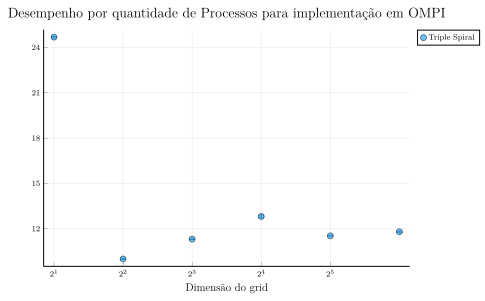

In [35]:
plot_results(ompi_triplespiral.processes, ompi_triplespiral.mean_duration, "Triple Spiral", 
    cuda_triplespiral.ci_duration,
    title = "Desempenho por quantidade de Processos para implementação em OMPI",
    xaxis = "Dimensão do grid", max_thread_power = 5)

### Cuda

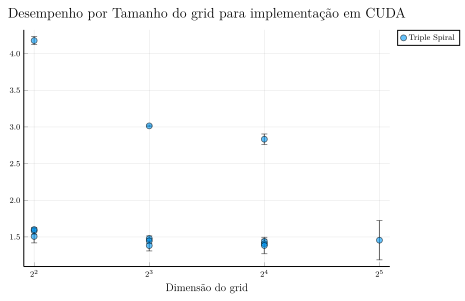

In [32]:
plot_results(cuda_triplespiral.griddim, cuda_triplespiral.mean_duration, "Triple Spiral", 
    cuda_triplespiral.ci_duration,
    title = "Desempenho por Tamanho do grid para implementação em CUDA",
    xaxis = "Dimensão do grid", max_thread_power = 5)

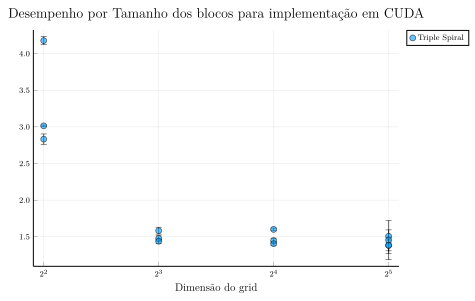

In [33]:
plot_results(cuda_triplespiral.blocos, cuda_triplespiral.mean_duration, "Triple Spiral", 
    cuda_triplespiral.ci_duration,
    title = "Desempenho por Tamanho dos blocos para implementação em CUDA",
    xaxis = "Dimensão do grid", max_thread_power = 5)

# Conclusões

`<<  em desenvolviemnto  >>`

true